# Efficiently loading ECCO NetCDF state estimate and model grid fields

## Objectives

Introduce routines for loading multiple ECCO NetCDF files at once.

## Introduction 

ECCOv4 NetCDF output fields are available in two formats.   


### Format 1: output frequency / variable name / year / month or day / tile

The first divides the output into small chunks, one file per llc90 tile and output time freqency.  For example:

* /eccov4r3_native_grid_netcdf_tiles/mon_mean/**VARIABLE_NAME**/year/month/**VARIABLE_NAME**\_tile_**NN**.nc
* /eccov4r3_native_grid_netcdf_tiles/mon_snapshot/**VARIABLE_NAME**/year/month/**VARIABLE_NAME**\_tile_**NN**.nc
* /eccov4r3_native_grid_netcdf_tiles/day_mean/**VARIABLE_NAME**/year/day/**VARIABLE_NAME**\_tile_**NN**.nc
* /eccov4r3_native_grid_netcdf_tiles/grid/

Where **VARIABLE_NAME** is the MITgcm name of the variable such as ``THETA`` or ``SALT`` and **NN** is the tile number [0, 1, ..., 12] 

In this format, 3D monthly-mean and monthly-snapshot fields are about 3mb and 2D fields are about 130kb


### Format 2: output frequency / variable name / year

The second format combines the tiles and months or days together for a given year:

* /eccov4r3_native_grid_netcdf/mon_mean/**VARIABLE_NAME**/**VARIABLE_NAME**\_**YYYY**.nc
* /eccov4r3_native_grid_netcdf/mon_snapshot/**VARIABLE_NAME**/**VARIABLE_NAME**\_**YYYY**.nc
* /eccov4r3_native_grid_netcdf/day_mean/**VARIABLE_NAME**/**VARIABLE_NAME**\_**YYYY**.nc
* /eccov4r3_native_grid_netcdf/grid/ECCOv4r3_grid.nc

Where **YYYY** is year of interest [1992..2015]

In this format, 3D (monthly-mean and monthly-snapshot) fields are about 265mb, 2D monthly-mean fields are 6mb, 2D daily-mean fields are about 150mb.


### Which format to use?

The choice of whether to work with many small files (format 1) or fewer large files depends on the analysis tools that you have available.  

The advantages of *Format 1* is that they don't require a machine with very much memory.  Small slices of the state estimate can be read and operated upon sequentially.  This may be helpful if you only need to analyze a small area or short time interval.  Each individual I/O operation is fast and the memory footprint is small but the I/O time per data element read is high.

The advantages of *Format 2* is that the I/O time per data element is smaller but this can come at the cost of higher memory required.  Loading one year of 3D field of potential temperature, salinity, velocity (u, v, w) costs 5x265 mb = 1.3gb of ram.  

However, if your analysis tool **doesn't require that you actually load the entire NetCDF file into memory** before then loading multiple fields in *Format 2* is by far the best choice.  Fortunately, the ``ecco_v4_py`` Python package leverages the ``xarray`` and ``Dask`` Python packages which enable just this capability.

Regardless of which format you prefer to use, this tutorial we will show you how to load multiple files simultaneously!

## Loading ECCO NetCDF files from tiles (Format 1)


So far in the previous tutorials we've loaded NetCDF files one tile at a time.  For example:

```
vvel_dataset = xr.open_dataset(data_dir + fname).load()
```

Two routines in the ``ecco_v4_py`` package faciliate loading and combining the 13 tile files of variables or model grid parameters located in a single directory.

1. `load_ecco_var_from_tiles_nc` 
2. `load_ecco_grid_from_tiles_nc`

And a third faciliates loading tile files of variables across multiple directories (times).

3. `recursive_load_ecco_var_from_tiles_nc`

These methods automate the loading of all 13 tiles.
Let's jump right in and use `load_ecco_grid_from_tiles_nc` to load all 13 GRID tile files.  

### Loading model grid fields with ``load_ecco_grid_from_tiles_nc``

First let's set up our environment...

In [32]:
import numpy as np
import xarray as xr
import sys
import matplotlib.pyplot as plt

sys.path.append('/Users/ifenty/ECCOv4-py')
import ecco_v4_py as ecco

# define a high-level directory for ECCO fields
ECCO_tiles_dir = '/Users/ifenty/eccov4r3_native_grid_netcdf_tiles/'

# Load one tile of the llc90 grid
grid_dir= ECCO_tiles_dir + 'grid'

Use our new routine to load all the ``grid`` files.  This routine loads each tile and concatenates them along a new *dimension* called $tile$.

In [2]:
grid_all_tiles = ecco.load_ecco_grid_from_tiles_nc(grid_dir).load()
grid_all_tiles.attrs = []

Let's look at `grid_all_tiles`:

In [3]:
grid_all_tiles

<xarray.Dataset>
Dimensions:  (i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_l: 50, k_p1: 51, k_u: 50, tile: 13)
Coordinates:
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49 50
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
    Zl       (k_l) float32 0.0 -10.0 -20.0 -30.0 ... -4834.0 -5244.5 -5678.0
    Zu       (k_u) float32 -10.0 -20.0 -30.0 -40.0 ... -5244.5 -5678.0 -6134.5
    Z        (k) float32 -5.0 -15.0 -25.0 -35.0 ... -5039.25 -5461.25 -5906.25
    Zp1 

#### Examining the ``grid_all_tiles`` ``Dataset`` object

##### 1. Dimensions
`Dimensions:  (i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_l: 50, k_p1: 51, k_u: 50, tile: 13)`

The *Dimensions* list includes a new dimension, **tile** of length 13.

##### 2. Dimension Coordinates
```
Coordinates:
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49 50
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * tile     (tile) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
``` 

Notice that **tile** coordinate now appears as an integer array: 0 .. 12.


##### 3. Non-Dimension Spatial Coordinates
```
Coordinates:
    Zl       (k_l) float32 0.0 -10.0 -20.0 -30.0 ... -4834.0 -5244.5 -5678.0
    Zu       (k_u) float32 -10.0 -20.0 -30.0 -40.0 ... -5244.5 -5678.0 -6134.5
    Z        (k) float32 -5.0 -15.0 -25.0 -35.0 ... -5039.25 -5461.25 -5906.25
    Zp1      (k_p1) float32 0.0 -10.0 -20.0 -30.0 ... -5244.5 -5678.0 -6134.5
    PHrefC   (k) float32 49.05 147.15 245.25 ... 49435.043 53574.863 57940.312
    PHrefF   (k_p1) float32 0.0 98.1 196.2 ... 51448.547 55701.18 60179.445
    drF      (k) float32 10.0 10.0 10.0 10.0 10.0 ... 387.5 410.5 433.5 456.5
    XC       (tile, j, i) float32 -111.60647 -111.303 ... -105.58465 -111.86579
    YC       (tile, j, i) float32 -88.24259 -88.382515 ... -88.07871 -88.10267
    XG       (tile, j_g, i_g) float32 -115.0 -115.0 ... -102.928925 -108.95171
    YG       (tile, j_g, i_g) float32 -88.17569 -88.31587 ... -87.9892 -88.02409
```

The non-dimension spatial coordinates that associated with depth are the same as when we loaded one tile at a time.  This makes sense because the model vertical grid is not a function of space.  

On the other hand, the latitude and longitude fields (XC,YC and XG,YG) now have **tile** as a new dimension indicating that the latitudes and longitudes are different for each tile.

To demonstrate, let's plot the latitudes and longitudes of two tiles, tile 6 (Arctic cap) and tile 2 (NE Atlantic and SE Atlantic). 

> **Note:** *Don't wory about the fancy Python below, you'll see how all of this works in later tutorials. They key is to notice that we are first **sel**ecting tile 6 and then **sel**ting tile 2.

In [4]:
grid_all_tiles

<xarray.Dataset>
Dimensions:  (i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_l: 50, k_p1: 51, k_u: 50, tile: 13)
Coordinates:
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49 50
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
    Zl       (k_l) float32 0.0 -10.0 -20.0 -30.0 ... -4834.0 -5244.5 -5678.0
    Zu       (k_u) float32 -10.0 -20.0 -30.0 -40.0 ... -5244.5 -5678.0 -6134.5
    Z        (k) float32 -5.0 -15.0 -25.0 -35.0 ... -5039.25 -5461.25 -5906.25
    Zp1 

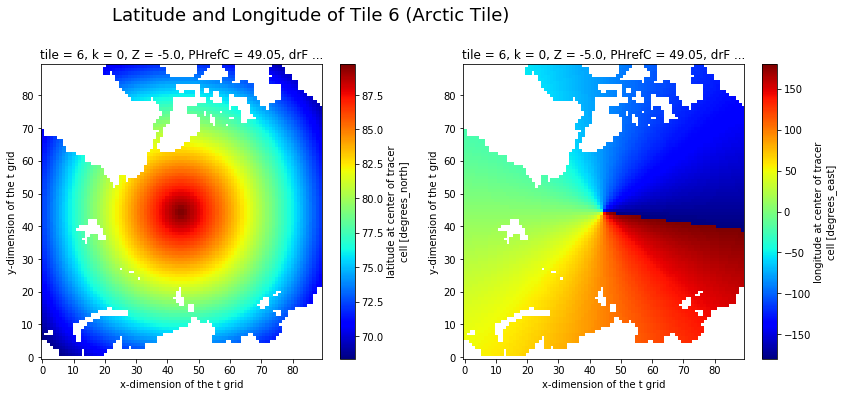

In [5]:
fig=plt.figure(figsize=(10, 10))
# create a subplot to the left to plot longitude
fig = plt.subplot(221)
# mask out the land in the latitude field
YC_masked = grid_all_tiles.YC.where(grid_all_tiles.hFacC.sel(k=0) != 0, np.nan)
# select out tile 6 and plot using the 'jet' colormap
YC_masked.sel(tile=6).plot(cmap='jet')

# repeat with longitude
plt.subplot(222)
XC_masked = grid_all_tiles.XC.where(grid_all_tiles.hFacC.sel(k=0) != 0, np.nan)
XC_masked.sel(tile=6).plot(cmap='jet')

# push the subplots away from each other a bit
plt.subplots_adjust(bottom=0, right=1.2, top=.9)
plt.suptitle('Latitude and Longitude of Tile 6 (Arctic Tile)', fontsize=18);

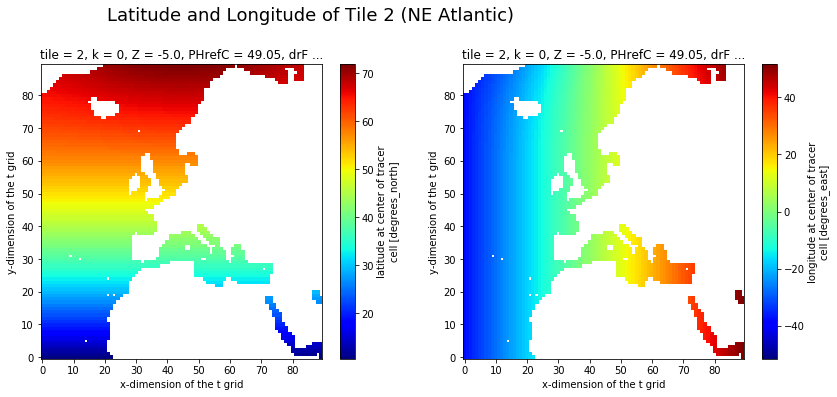

In [6]:
fig=plt.figure(figsize=(10, 10))

#  tile 2 latitude 
plt.subplot(221)
YC_masked = grid_all_tiles.YC.where(grid_all_tiles.hFacC.sel(k=0) != 0, np.nan)
YC_masked.sel(tile=2).plot(cmap='jet')

#  tile 2 longitude
plt.subplot(222)
XC_masked = grid_all_tiles.XC.where(grid_all_tiles.hFacC.sel(k=0) != 0, np.nan)
XC_masked.sel(tile=2).plot(cmap='jet')

plt.subplots_adjust(bottom=0, right=1.2, top=.9)
plt.suptitle('Latitude and Longitude of Tile 2 (NE Atlantic)', fontsize=18);

Clearly XC and YC vary as a function of tile!

#### 3. Grid Geometry Parameters and Ancillary Information
```
Coordinates:
    dxC      (tile, j, i_g) float32 15583.418 15588.104 ... 23865.428 23406.256
    rAs      (tile, j_g, i) float32 179944260.0 180486990.0 ... 364150620.0
    rAw      (tile, j, i_g) float32 361699460.0 362790240.0 ... 364760350.0
    Depth    (tile, j, i) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    rA       (tile, j, i) float32 362256450.0 363300960.0 ... 361119100.0
    dxG      (tile, j_g, i) float32 15584.907 15589.316 ... 23600.436 23142.107
    dyG      (tile, j, i_g) float32 23210.262 23273.26 ... 15595.26 15583.685
    rAz      (tile, j_g, i_g) float32 179944260.0 180486990.0 ... 364150620.0
    dyC      (tile, j_g, i) float32 11563.718 11593.785 ... 15585.765 15578.138
    hFacS    (tile, k, j_g, i) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    hFacC    (tile, k, j, i) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    hFacW    (tile, k, j, i_g) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
```

llc90 grid cell geometries vary with tile.  For example, consider grid cell areas of tile 1 (SE Atlantic) and tile 2 (NE Atlantic)

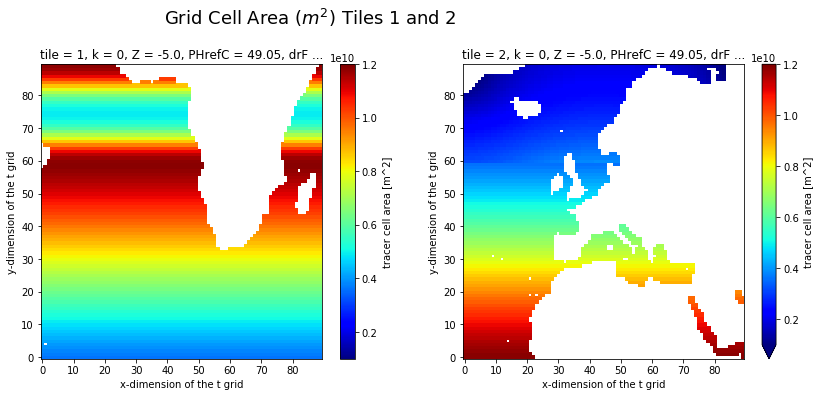

In [7]:
fig=plt.figure(figsize=(10, 10))

#  tile 6 grid cell area (m^2)
plt.subplot(221)
rA_masked_6 = grid_all_tiles.rA.where(grid_all_tiles.hFacC.sel(k=0) != 0, np.nan)
rA_masked_6.sel(tile=1).plot(cmap='jet', vmin=1e9, vmax=1.2e10)

#  tile 1 grid cell area (m^2)
plt.subplot(222)
rA_masked_1 = grid_all_tiles.rA.where(grid_all_tiles.hFacC.sel(k=0) != 0, np.nan)
rA_masked_1.sel(tile=2).plot(cmap='jet', vmin=1e9, vmax=1.2e10)

plt.subplots_adjust(bottom=0, right=1.2, top=.9)
plt.suptitle('Grid Cell Area ($m^2$) Tiles 1 and 2', fontsize=18);

### Loading all 13 tiles of a state estimate field with ``load_ecco_var_from_tiles_nc``

The routine ``load_ecco_var_from_tiles_nc`` loads all 13 tiles of a model output variable of name **var_name** from a single directory:

Let's demonstrate with ``THETA``

In [8]:
# Load one tile of the llc90 grid
data_dir= ECCO_tiles_dir + '/mon_mean/THETA/2010/03/'

theta_dataset = ecco.load_ecco_var_from_tiles_nc(data_dir, 'THETA').load()
theta_dataset.attrs =[]
theta_dataset

<xarray.Dataset>
Dimensions:    (i: 90, j: 90, k: 50, nv: 2, tile: 13)
Coordinates:
  * j          (j) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * i          (i) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k          (k) int32 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
    Z          (k) float32 -5.0 -15.0 -25.0 -35.0 ... -5039.25 -5461.25 -5906.25
    PHrefC     (k) float32 49.05 147.15 245.25 ... 49435.043 53574.863 57940.312
    drF        (k) float32 10.0 10.0 10.0 10.0 10.0 ... 387.5 410.5 433.5 456.5
    time_bnds  (nv) datetime64[ns] 2010-03-01 2010-04-01
    iter       int32 159948
    time       datetime64[ns] 2010-03-16T12:00:00
    XC         (tile, j, i) float32 -111.60647 -111.303 ... -111.86579
    YC         (tile, j, i) float32 -88.24259 -88.382515 ... -88.07871 -88.10267
    rA         (tile, j, i) float32 362256450.0 363300960.0 ... 361119100.0
    hFacC      (tile, k, j, i) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0

As with our grid field, we see ``THETA`` now has $tile$ as a new dimension.  The array of ``THETA`` is now $(tile, k, j, i)$.   Quickly, let's plot ``THETA`` for two different tiles:

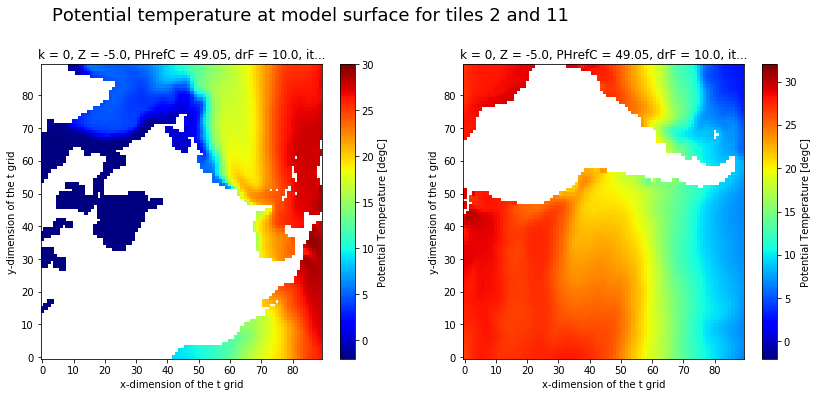

In [9]:
fig=plt.figure(figsize=(10, 10))

#  tile 2 T 
plt.subplot(221)
T_ma = theta_dataset.THETA.where(grid_all_tiles.hFacC != 0, np.nan)
T_ma.sel(tile=10, k=0).plot(cmap='jet', vmin=-2, vmax=30)

#  tile 2 T
plt.subplot(222)
T_ma = theta_dataset.THETA.where(grid_all_tiles.hFacC != 0, np.nan)
T_ma.sel(tile=11, k=0).plot(cmap='jet', vmin=-2, vmax=32)

plt.subplots_adjust(bottom=0, right=1.2, top=.9)
plt.suptitle('Potential temperature at model surface for tiles 2 and 11', fontsize=18);

> Note :: Tiles 2 and 11 were intentionally selected here to remind you that llc90 tiles 7-12 are rotated by 90 degrees relative to tiles 0-5. For tiles 7-12, the x-axis is approximately  north-south while y-axis is approximately east-west


### Loading a subset of tiles or vertical levels

Both ``load_ecco_var_from_tiles_nc`` and ``load_ecco_grid_from_tiles_nc`` allow the user to specify particular tiles and/or depth levels using optional arguments with the 
*tiles_to_load* and *k_subset* optional arguments.  

By default 

* *tiles_to_load* is [0,1,2,3,4,5,6,7,8,9,10,11,12] or range(13)
* k_subset = []


To load only particular tiles, provide *tiles_to_load* a subset list with the desired tile indices.  Similarly, to load only particular depth levels, provide *k_subset* a subset list of desired depth level indices. 

For example, the following call loads ``THETA`` for tiles 0-5 and depth levels 0-10:

In [10]:
theta_dataset = ecco.load_ecco_var_from_tiles_nc(data_dir, 'THETA', \
                                                 tiles_to_load = [0,1,2,3,4,5], \
                                                 k_subset=[0,1,2,3,4,5,6,7,8,9,10]).load()
theta_dataset.attrs = []
theta_dataset.THETA

<xarray.DataArray 'THETA' (tile: 6, k: 11, j: 90, i: 90)>
array([[[[0.000000e+00, ..., 0.000000e+00],
         ...,
         [2.607735e+00, ..., 1.944377e+00]],

        ...,

        [[0.000000e+00, ..., 0.000000e+00],
         ...,
         [1.108904e+00, ..., 1.277304e-02]]],


       ...,


       [[[2.785707e+01, ..., 2.806310e+01],
         ...,
         [0.000000e+00, ..., 0.000000e+00]],

        ...,

        [[2.190366e+01, ..., 2.595283e+01],
         ...,
         [0.000000e+00, ..., 0.000000e+00]]]], dtype=float32)
Coordinates:
  * j        (j) int32 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * i        (i) int32 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * k        (k) int32 0 1 2 3 4 5 6 7 8 9 10
    Z        (k) float32 -5.0 -15.0 -25.0 -35.0 ... -85.025 -95.095 -105.31
    PHrefC   (k) float32 49.05 147.15 245.25 ... 834.0953 932.88196 1033.0911
    drF      (k) float32 10.0 10.0 10.0 10.0 10.0 ... 10.01 10.03 10.11 10.32
    iter     in

Note that the $k$ dimension is length 11 and the $tile$ dimension is length 6.  The ``tile`` dimension coordinate has values [0,1,2,3,4,5] as requested.

### Loading several state estimate fields with ``recursive_load_ecco_var_from_tiles_nc``

With ``recursive_load_ecco_var_from_tiles_nc`` you can load multiple time levels from a single variable or many variables.  Specify:

1. a top level directory, 
2. a list of variables to load
3. a list of tiles to load
4. a list of years to load
5. a list of vertical level to load

and this routine will search through all subdirectories and load all appropriate $tile$ files.


#### Loading several years of **one** state estimate field

Let's use this recursive load routine to load all monthly-mean ``SSH`` and ``THETA`` fields from tiles 0-2 for the year 2010 and depth level 10:

In [11]:
# Load one tile of the llc90 grid
ssh_dir= ECCO_tiles_dir + '/mon_mean/SSH/2010/'

SSH_2010 = \
    ecco.recursive_load_ecco_var_from_tiles_nc(ssh_dir, \
                                                  'SSH', \
                                                  tiles_to_load = [0,1,2],
                                                  years_to_load = 2010,
                                                  k_subset = 10).load()
SSH_2010.attrs = []

searching 01 for variables 
searching 02 for variables 
searching 03 for variables 
searching 04 for variables 
searching 05 for variables 
searching 06 for variables 
searching 07 for variables 
searching 08 for variables 
searching 09 for variables 
searching 10 for variables 
searching 11 for variables 
searching 12 for variables 
located directories with SSH 


In [12]:
SSH_2010

<xarray.Dataset>
Dimensions:    (i: 90, j: 90, nv: 2, tile: 3, time: 12)
Coordinates:
  * j          (j) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * i          (i) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
    XC         (tile, j, i) float32 -111.60647 -111.303 ... 51.44421 51.837925
    YC         (tile, j, i) float32 -88.24259 -88.382515 ... 67.53387 67.47211
    rA         (tile, j, i) float32 362256450.0 363300960.0 ... 212633870.0
  * tile       (tile) int32 0 1 2
    time_bnds  (time, nv) datetime64[ns] 2010-01-01 2010-02-01 ... 2011-01-01
    iter       (time) int32 158532 159204 159948 160668 ... 165084 165804 166548
  * time       (time) datetime64[ns] 2010-01-16T12:00:00 ... 2010-12-16T12:00:00
Dimensions without coordinates: nv
Data variables:
    SSH        (time, tile, j, i) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

The resulting field has 3 tiles [0,1,2] and 12 time levels one for each month of 2010!

In [13]:
SSH_2010.time

<xarray.DataArray 'time' (time: 12)>
array(['2010-01-16T12:00:00.000000000', '2010-02-15T00:00:00.000000000',
       '2010-03-16T12:00:00.000000000', '2010-04-16T00:00:00.000000000',
       '2010-05-16T12:00:00.000000000', '2010-06-16T00:00:00.000000000',
       '2010-07-16T12:00:00.000000000', '2010-08-16T12:00:00.000000000',
       '2010-09-16T00:00:00.000000000', '2010-10-16T12:00:00.000000000',
       '2010-11-16T00:00:00.000000000', '2010-12-16T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    iter     (time) int32 158532 159204 159948 160668 ... 165084 165804 166548
  * time     (time) datetime64[ns] 2010-01-16T12:00:00 ... 2010-12-16T12:00:00
Attributes:
    long_name:      center time of averaging period
    standard_name:  time
    bounds:         time_bnds
    axis:           T

#### Loading several years of **multiple** state estimate fields

Now let's use the recursive load tile routine to load all monthly-mean ``SSH``, ``THETA``, and ``SALT`` fields from tile 6.  Use the directory that contains the variables as the the top-level directory.  The routine will recursively search all subdirectories for these fields.

> Note :: This operation may take a minute because it is loading 365x3 2D fields

In [14]:
var_dir= ECCO_tiles_dir + '/day_mean/'

SSH_THETA_SALT = \
    ecco.recursive_load_ecco_var_from_tiles_nc(var_dir, \
                                               ['SSH', 'THETA','SALT'], \
                                               tiles_to_load = [6], \
                                               years_to_load=2010, \
                                               less_output=True)

searching ETAN for variables 
searching OBP for variables 
searching PHIBOT for variables 
searching SALT for variables 
searching SIarea for variables 
searching SIheff for variables 
searching SIhsnow for variables 
searching SSH for variables 
searching THETA for variables 
searching sIceLoad for variables 
located directories with SSH 
located directories with THETA 
located directories with SALT 


In [15]:
SSH_THETA_SALT

<xarray.Dataset>
Dimensions:    (i: 90, j: 90, nv: 2, time: 365)
Coordinates:
    XC         (j, i) float32 52.0 52.331654 52.769016 ... -127.66834 -128.0
    YC         (j, i) float32 67.57341 67.67698 67.79265 ... 67.67698 67.57341
    rA         (j, i) float32 246414940.0 412417600.0 ... 246414940.0
  * j          (j) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * i          (i) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
    tile       int32 6
    time_bnds  (time, nv) datetime64[ns] dask.array<shape=(365, 2), chunksize=(2, 2)>
    iter       (time) int32 157812 157836 157860 157884 ... 166500 166524 166548
  * time       (time) datetime64[ns] 2010-01-01T12:00:00 ... 2010-12-31T12:00:00
Dimensions without coordinates: nv
Data variables:
    SALT       (time, j, i) float32 dask.array<shape=(365, 90, 90), chunksize=(1, 90, 90)>
    THETA      (time, j, i) float32 dask.array<shape=(365, 90, 90), chunksize=(1, 90, 90)>
    SSH        (time, j, i) float3

The resulting *SSH_THETA_SALT* ``DATASET`` object has ``SALT``, ``THETA``, and ``SSH`` as data variables.  That's pretty cool.


## Loading ECCO NetCDF files aggregated by year (Format 2)

Finally, we'll show how to load ECCO NetCDF files aggregated by year.  These routines mirror those used above and therefore this part of the tutorial is brief.

### Loading model *grid* fields

In Format 2, all 13 tiles are aggregated so the model **grid** is in one file. Load it using the ``open_dataset`` routine from ``xarray``. 

> Note :: Please notice that the top-level directory for ECCOv4 NetCDF files aggregated by year (Format 2) will be different than those separated by time and tile (Format 1)!!

In [16]:
# define a high-level directory for ECCO fields
ECCO_dir = '/Users/ifenty/eccov4r3_native_grid_netcdf/'

# Load one tile of the llc90 grid
grid_dir= ECCO_dir + 'grid/'

grid = xr.open_dataset(grid_dir + 'ECCOv4r3_grid.nc')
grid.attrs = []
grid

<xarray.Dataset>
Dimensions:  (i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_l: 50, k_p1: 51, k_u: 50, tile: 13)
Coordinates:
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49 50
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * tile     (tile) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    XC       (tile, j, i) float32 ...
    YC       (tile, j, i) float32 ...
    XG       (tile, j_g, i_g) float32 ...
    YG       (tile, j_g, i_g) float32 ...
    Zl       (k_l) float32 .

all 13 tiles are present in this single file.

### Loading a single year of a state estimate field 

In Format 2, all 13 tiles are aggregated and all fields for a given year are aggregated so to load a single year of a state estimate field we can use the ``open_dataset`` routine from ``xarray``.  Let's open one year's worth of daily sea ice concentration fields from 2010.

In [17]:
siarea_dir= ECCO_dir + 'day_mean/SIarea/'

siarea_dataset = xr.open_dataset(siarea_dir + '/SIarea_2010.nc')
siarea_dataset.attrs = []
siarea_dataset.SIarea

<xarray.DataArray 'SIarea' (time: 365, tile: 13, j: 90, i: 90)>
[38434500 values with dtype=float32]
Coordinates:
    iter     (time) int32 ...
  * time     (time) datetime64[ns] 2010-01-01T12:00:00 ... 2010-12-31T12:00:00
  * j        (j) int32 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * i        (i) int32 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
    XC       (tile, j, i) float32 ...
    YC       (tile, j, i) float32 ...
    rA       (tile, j, i) float32 ...
  * tile     (tile) int32 0 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    units:          1
    long_name:      SEAICE fractional ice-covered area [0 to 1]
    standard_name:  sea_ice_area_fraction

``SIarea`` has 13 tiles, 365 days.

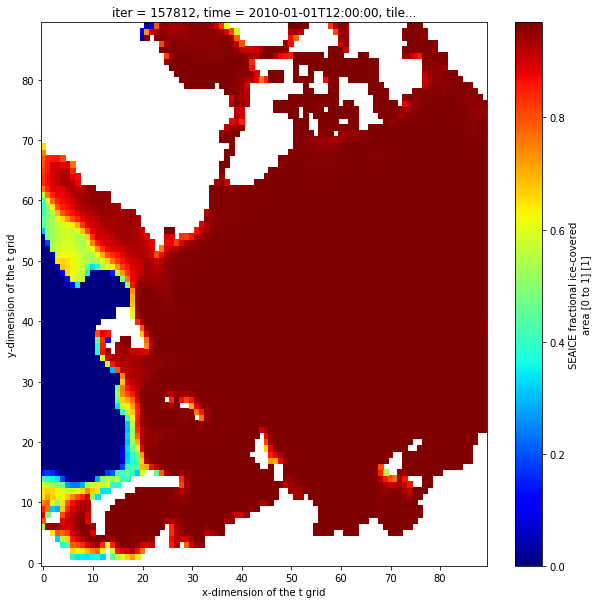

In [18]:
fig=plt.figure(figsize=(10, 10))
s_ma_jan0 = siarea_dataset.SIarea.isel(time=0)
si_ma = s_ma_jan0.where(grid.hFacC.isel(k=0) != 0, np.nan)
si_ma.isel(tile=6).plot(cmap='jet')

### Loading several years of a state estimate field using ``load_ecco_var_from_years_nc``

Loading several years of a single tate estimate field is easy with  ``load_ecco_var_from_years_nc``.  You can specify *tile_to_load* and *k_subset* if you like, but that is purely optional:

In [19]:
si_area_subset = ecco.load_ecco_var_from_years_nc(siarea_dir, \
                                                  'SIarea', 2010, \
                                                  tiles_to_load = [2,5,6,7,10]).load()
si_area_subset.attrs = []
si_area_subset

<xarray.Dataset>
Dimensions:    (i: 90, j: 90, nv: 2, tile: 5, time: 365)
Coordinates:
    time_bnds  (time, nv) datetime64[ns] 2010-01-01 2010-01-02 ... 2011-01-01
    iter       (time) int32 157812 157836 157860 157884 ... 166500 166524 166548
  * time       (time) datetime64[ns] 2010-01-01T12:00:00 ... 2010-12-31T12:00:00
  * j          (j) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * i          (i) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
    XC         (tile, j, i) float32 -37.5 -36.5 -35.5 ... -38.5 -38.5 -38.5
    YC         (tile, j, i) float32 10.458642 10.458642 ... 11.438585 10.458642
    rA         (tile, j, i) float32 11896091000.0 ... 11896091000.0
  * tile       (tile) int32 2 5 6 7 10
Dimensions without coordinates: nv
Data variables:
    SIarea     (time, tile, j, i) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

Our ``SIarea`` field has 5 tiles for 2010.

### Loading several years of a state estimate fields using ``recursive_load_ecco_var_from_years_nc``

With ``recursive_load_ecco_var_from_years_nc`` one can specify one or more variables to load, one or more years to load, a subset of tiles and subset of vertical levels.  Let's demonstrate by loading up all daily-averaged ``SSH`` ```SSS``` and ``SST`` ad fields for the year 2010.

> Note :: This operation is relatively fast because there are fewer coordinate variables to reload (3 as opposed to the 365 x 3 when we loaded these same fields split into tiles)

In [20]:
day_mean_dir= ECCO_dir + 'day_mean/'

SSH_THETA_2010 = ecco.recursive_load_ecco_var_from_years_nc(day_mean_dir, \
                                           vars_to_load=['SSH','THETA', 'SALT'], \
                                           years_to_load='all').load()
                                           

searching /Users/ifenty/eccov4r3_native_grid_netcdf/day_mean/ for variables ... 
found  ['ETAN', 'OBP', 'PHIBOT', 'SALT', 'SIarea', 'SIheff', 'SIhsnow', 'SSH', 'THETA', 'sIceLoad'] 

finished searching for SALT ... success!
finished searching for SSH ... success!
finished searching for THETA ... success!


In [21]:
SSH_THETA_2010

<xarray.Dataset>
Dimensions:    (i: 90, j: 90, nv: 2, tile: 13, time: 365)
Coordinates:
    time_bnds  (time, nv) datetime64[ns] 2010-01-01 2010-01-02 ... 2011-01-01
    iter       (time) int32 157812 157836 157860 157884 ... 166500 166524 166548
  * time       (time) datetime64[ns] 2010-01-01T12:00:00 ... 2010-12-31T12:00:00
  * j          (j) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * i          (i) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
    XC         (tile, j, i) float32 -111.60647 -111.303 ... -111.86579
    YC         (tile, j, i) float32 -88.24259 -88.382515 ... -88.07871 -88.10267
    rA         (tile, j, i) float32 362256450.0 363300960.0 ... 361119100.0
  * tile       (tile) int32 0 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nv
Data variables:
    THETA      (time, tile, j, i) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    SSH        (time, tile, j, i) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    SALT       (time, 

## "Loading" the entire ECCOv4 dataset using Dask


``ecco_v4_py`` leverages the amazing ``Dask`` capabilities via the ``xarray`` package.  What are these capabilities?  For our purposes, there are two, quoting from the ``Dask`` website, 
https://docs.dask.org/

1. **Larger-than-memory:** Lets you work on datasets that are larger than your available memory by breaking up your array into many small pieces, operating on those pieces in an order that minimizes the memory footprint of your computation, and effectively streaming data from disk.*

2. **Blocked Algorithms:** Perform large computations by performing many smaller computations

In cluster environments ``Dask`` can distribute computations across many cores to speed up large redundant calculation.  A full description of ``Dask`` is far, far outside the scope of this tutorial.  For the moment, let us compare the operation of loading **all** the 2D daily-mean fields for 2010 both using ``Dask`` and without using ``Dask``.  Without ``Dask`` these fields will be loaded into memory.  With ``Dask`` we will only load a minimum of the ``Datasets``, the Dimensions and Coordinates.

To demonstate some of the advantages of using ``DASK`` to load and analyze ECCO fields, let's load a large subset of monthly mean fields with and without ``Dask``.  Then we'll load all of the monthly-mean fields for one year.  At the end we'll compare their *times to load* and *memory footprints*.

### Example 1: No Dask

In [22]:
mon_mean_dir= ECCO_dir + 'mon_mean/'

import time
t_0 = time.time()
vars_to_load = ['ADVr_SLT', 'ADVr_TH', 'ADVxHEFF', 'ADVxSNOW', \
                'ADVx_SLT', 'ADVx_TH', 'ADVyHEFF', 'ADVySNOW', \
                'ADVy_SLT', 'ADVy_TH', 'DFrE_SLT', 'DFrE_TH', \
                'DFrI_SLT', 'DFrI_TH', 'DFxEHEFF', 'DFxESNOW', \
                'DFxE_SLT', 'DFxE_TH', 'DFyEHEFF', 'DFyESNOW', \
                'DFyE_SLT', 'DFyE_TH', 'DRHODR', 'ETAN', 'EXFaqh',\
                'EXFatemp', 'EXFempmr', 'EXFevap', 'EXFhl', 'EXFhs', \
                'EXFlwdn', 'EXFlwnet', 'EXFpreci', 'EXFqnet', 'EXFroff']

large_subset_no_dask = ecco.recursive_load_ecco_var_from_years_nc(mon_mean_dir, \
                                           vars_to_load=vars_to_load, \
                                           years_to_load=2010).load()
delta_t_no_dask =  time.time() - t_0

searching /Users/ifenty/eccov4r3_native_grid_netcdf/mon_mean/ for variables ... 
found  ['ADVr_SLT', 'ADVr_TH', 'ADVxHEFF', 'ADVxSNOW', 'ADVx_SLT', 'ADVx_TH', 'ADVyHEFF', 'ADVySNOW', 'ADVy_SLT', 'ADVy_TH', 'DFrE_SLT', 'DFrE_TH', 'DFrI_SLT', 'DFrI_TH', 'DFxEHEFF', 'DFxESNOW', 'DFxE_SLT', 'DFxE_TH', 'DFyEHEFF', 'DFyESNOW', 'DFyE_SLT', 'DFyE_TH', 'DRHODR', 'ETAN', 'EXFaqh', 'EXFatemp', 'EXFempmr', 'EXFevap', 'EXFhl', 'EXFhs', 'EXFlwdn', 'EXFlwnet', 'EXFpreci', 'EXFqnet', 'EXFroff', 'EXFswdn', 'EXFswnet', 'EXFtaux', 'EXFtauy', 'EXFuwind', 'EXFvwind', 'EXFwspee', 'GM_PsiX', 'GM_PsiY', 'MXLDEPTH', 'OBP', 'PHIBOT', 'PHIHYD', 'PHIHYDcR', 'RHOAnoma', 'SALT', 'SFLUX', 'SIarea', 'SIatmFW', 'SIatmQnt', 'SIheff', 'SIhsnow', 'SIsnPrcp', 'SIuice', 'SIvice', 'SSH', 'TFLUX', 'THETA', 'UVEL', 'UVELMASS', 'Um_dPHdx', 'VVEL', 'VVELMASS', 'Vm_dPHdy', 'WVELMASS', 'oceFWflx', 'oceQnet', 'oceQsw', 'oceSPDep', 'oceSPflx', 'oceSPtnd', 'oceTAUX', 'oceTAUY', 'sIceLoad'] 

finished searching for ADVr_SLT ... succe

In [23]:
print ('\nloaded  large_subset_no_dask in %d seconds ' % delta_t_no_dask)


loaded  large_subset_no_dask in 15 seconds 


In [24]:
t_0 = time.time()
large_subset_with_dask = ecco.recursive_load_ecco_var_from_years_nc(mon_mean_dir, \
                                           vars_to_load=vars_to_load, \
                                           years_to_load=2010)
delta_t_with_dask =  time.time() - t_0

searching /Users/ifenty/eccov4r3_native_grid_netcdf/mon_mean/ for variables ... 
found  ['ADVr_SLT', 'ADVr_TH', 'ADVxHEFF', 'ADVxSNOW', 'ADVx_SLT', 'ADVx_TH', 'ADVyHEFF', 'ADVySNOW', 'ADVy_SLT', 'ADVy_TH', 'DFrE_SLT', 'DFrE_TH', 'DFrI_SLT', 'DFrI_TH', 'DFxEHEFF', 'DFxESNOW', 'DFxE_SLT', 'DFxE_TH', 'DFyEHEFF', 'DFyESNOW', 'DFyE_SLT', 'DFyE_TH', 'DRHODR', 'ETAN', 'EXFaqh', 'EXFatemp', 'EXFempmr', 'EXFevap', 'EXFhl', 'EXFhs', 'EXFlwdn', 'EXFlwnet', 'EXFpreci', 'EXFqnet', 'EXFroff', 'EXFswdn', 'EXFswnet', 'EXFtaux', 'EXFtauy', 'EXFuwind', 'EXFvwind', 'EXFwspee', 'GM_PsiX', 'GM_PsiY', 'MXLDEPTH', 'OBP', 'PHIBOT', 'PHIHYD', 'PHIHYDcR', 'RHOAnoma', 'SALT', 'SFLUX', 'SIarea', 'SIatmFW', 'SIatmQnt', 'SIheff', 'SIhsnow', 'SIsnPrcp', 'SIuice', 'SIvice', 'SSH', 'TFLUX', 'THETA', 'UVEL', 'UVELMASS', 'Um_dPHdx', 'VVEL', 'VVELMASS', 'Vm_dPHdy', 'WVELMASS', 'oceFWflx', 'oceQnet', 'oceQsw', 'oceSPDep', 'oceSPflx', 'oceSPtnd', 'oceTAUX', 'oceTAUY', 'sIceLoad'] 

finished searching for ADVr_SLT ... succe

In [25]:
print ('\nloaded  large_subset_with_dask in %d seconds ' % delta_t_with_dask)


loaded  large_subset_with_dask in 12 seconds 


In [26]:
t_0 = time.time()
all_fields_with_dask = ecco.recursive_load_ecco_var_from_years_nc(mon_mean_dir, \
                                           vars_to_load='all', \
                                           years_to_load=2010)
delta_t_all_with_dask =  time.time() - t_0

searching /Users/ifenty/eccov4r3_native_grid_netcdf/mon_mean/ for variables ... 
found  ['ADVr_SLT', 'ADVr_TH', 'ADVxHEFF', 'ADVxSNOW', 'ADVx_SLT', 'ADVx_TH', 'ADVyHEFF', 'ADVySNOW', 'ADVy_SLT', 'ADVy_TH', 'DFrE_SLT', 'DFrE_TH', 'DFrI_SLT', 'DFrI_TH', 'DFxEHEFF', 'DFxESNOW', 'DFxE_SLT', 'DFxE_TH', 'DFyEHEFF', 'DFyESNOW', 'DFyE_SLT', 'DFyE_TH', 'DRHODR', 'ETAN', 'EXFaqh', 'EXFatemp', 'EXFempmr', 'EXFevap', 'EXFhl', 'EXFhs', 'EXFlwdn', 'EXFlwnet', 'EXFpreci', 'EXFqnet', 'EXFroff', 'EXFswdn', 'EXFswnet', 'EXFtaux', 'EXFtauy', 'EXFuwind', 'EXFvwind', 'EXFwspee', 'GM_PsiX', 'GM_PsiY', 'MXLDEPTH', 'OBP', 'PHIBOT', 'PHIHYD', 'PHIHYDcR', 'RHOAnoma', 'SALT', 'SFLUX', 'SIarea', 'SIatmFW', 'SIatmQnt', 'SIheff', 'SIhsnow', 'SIsnPrcp', 'SIuice', 'SIvice', 'SSH', 'TFLUX', 'THETA', 'UVEL', 'UVELMASS', 'Um_dPHdx', 'VVEL', 'VVELMASS', 'Vm_dPHdy', 'WVELMASS', 'oceFWflx', 'oceQnet', 'oceQsw', 'oceSPDep', 'oceSPflx', 'oceSPtnd', 'oceTAUX', 'oceTAUY', 'sIceLoad'] 

finished searching for ADVr_SLT ... succe

In [27]:
print ('\nloaded  all_with_dask in %d seconds ' % delta_t_all_with_dask)


loaded  all_with_dask in 67 seconds 


The real advantage comes when examining the size of these objects in memory.  Use the following routine from https://goshippo.com/blog/measure-real-size-any-python-object/ 


**execute the cell below to make the function available**

In [28]:
def get_size(obj, seen=None):
    """Recursively finds size of objects"""
    size = sys.getsizeof(obj)
    if seen is None:
        seen = set()
    obj_id = id(obj)
    if obj_id in seen:
        return 0
    # Important mark as seen *before* entering recursion to gracefully handle
    # self-referential objects
    seen.add(obj_id)
    if isinstance(obj, dict):
        size += sum([get_size(v, seen) for v in obj.values()])
        size += sum([get_size(k, seen) for k in obj.keys()])
    elif hasattr(obj, '__dict__'):
        size += get_size(obj.__dict__, seen)
    elif hasattr(obj, '__iter__') and not isinstance(obj, (str, bytes, bytearray)):
        size += sum([get_size(i, seen) for i in obj])
    return size

In [29]:
print(get_size(large_subset_no_dask))
print(get_size(large_subset_with_dask))
print(get_size(all_fields_with_dask))

46090763
175883
319611


Using ``Dask``, we were able to load every monthly mean field for an entire year in just over one minute.  That means one can use ``Dask`` to have all monthly-mean fields of the ECCOv4 state estimate avaiable to perform calculations on in about half an hour.

In terms of memory, the *all_fields_with_dask* object takes less than 1% of the memory of *large_subset_no_dask*.  With much less memory reserved to hold all of the fields, we have more memory avaiable for calculations on the parts of the fields that we care about.

Go ahead and experiment with using ``Dask`` to load the daily-averaged fields.  Because all of the daily-averaged fields in the standard ECCO product are 2D, loading them with ``Dask`` takes very little time!

## Summary

Now you know how effecient ways to load ECCOv4 NetCDF files, both when you are reading variables split into *tiles*  and when you are reading variables aggregated by year.

Using ``Dask`` we showed that one can prepare a work environment where ECCO model variables are accessible for calculations even without fully loading the fields into memory.